<a href="https://colab.research.google.com/github/anoukzwinkels/TM10007/blob/master/Curves_TM10007_group_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting tumor stage in head and neck cancer with machine learning

*Written by group 14: Merel Flinsenberg [4663179], Femke Leenen [4664485], Floor Smits [4533143] & Anouk Zwinkels [4679962]*

---

This code was written for the Machine Learning course of the master Technical Medicine from the Delft University of Technology. The aim of the code is to build a classifier that can predict the tumor stage in head and neck cancer based on chosen features. When succeeded, an biopsy or resection is no longer needed. Instead, a CT scan will be sufficient to determine the malignancy of the tumor. Today, due to manual assessment, quantification of the CT scans is still observer-dependent, subjective and difficult. Machine learning can solve this problem.

Between the cells of code, the choices made are briefly explained and motivated. More details can be found in the report. 



## Data loading and cleaning

First, all data is loaded from github. After this, all the required packages are imported.

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hn.load_data               import load_data
from sklearn.model_selection    import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection    import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.model_selection    import validation_curve
from sklearn.model_selection    import train_test_split
from sklearn.model_selection    import learning_curve
from sklearn.model_selection    import ShuffleSplit
from sklearn.feature_selection  import VarianceThreshold, RFECV, SelectKBest, f_classif
from sklearn.metrics            import accuracy_score
from sklearn.metrics            import roc_auc_score
from sklearn.preprocessing      import RobustScaler
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.svm                import SVC
from sklearn.decomposition      import PCA

from plotly.express             import scatter_3d, bar
from sklearn.ensemble           import RandomForestClassifier

from sklearn.naive_bayes        import GaussianNB
from sklearn.datasets           import load_digits


In [ ]:
def def_data():
  '''
  Load the data
  
  :return features:     dataframe containing the features
  :return labels:       dataframe containing the labels
  '''
  
  # load the data
  data = load_data()

  # split the labels from the features
  features = data.drop(columns=['label'])
  labels = pd.DataFrame(data['label'])

  return features, labels

In [ ]:
def remove_outliers(X_train):
  '''
  Identify the outliers and replace them with the minimum or maximum value of the corresponding feature.

  :param X_train:      dataframe containing the features of the traindata
  :return X_train:     dataframe containing the features of the traindata with the outliers corrected
  '''
  # make a copy of X_train to fill in the corrected outliers
  X_train = X_train.copy()

  # calculate interquartile range
  q25, q75 = np.percentile(X_train, 25,axis=0), np.percentile(X_train, 75,axis=0)
  iqr = q75 - q25

  # calculate the outlier cutoff
  cut_off = iqr * 1.5
  lower, upper = q25 - cut_off, q75 + cut_off

  # identify the outliers
  outliers = (X_train < lower) | (X_train > upper)

  # make a dataframe without the outliers. This is needed to calculate the min and max value.
  feature_nan = X_train[:].copy()
  feature_nan[outliers] = np.nan

  # make a list of the feature names. This is needed to isolate the column, as the outliers are corrected separately for each column. 
  feature_names = list(X_train.columns)
  for col in feature_names:
    # isolate the column
    outliers_col = outliers[col]
    # get the value (val) of the outlier
    for val in X_train.loc[outliers_col,col]:
      # if the outlier is greater than the max value (non-outliers), it is replaced by this max value.
      if val > np.nanmax(feature_nan[col]):
        X_train[col] = X_train[col].replace(to_replace = val, value = np.nanmax(feature_nan[col]))
      # if the outlier is less than the min value (non-outliers), it is replaced by this min value.
      elif val < np.nanmin(feature_nan[col]):
        X_train[col] = X_train[col].replace(to_replace = val, value = np.nanmin(feature_nan[col]))
        
  return (X_train)

# Feature selection

To choose which features will be used in the classification, feature selection is performed. Two different methods of feature selection are used together to achieve the best features. The two methods and why they were used will be briefly explained separately prior to the corresponding code of the method. 

In [ ]:
def remove_zero_variance(X_train, X_test):
  '''
  Remove the features with zero variance. The data is fitted on the X_train and applied to X_train and X_test.

  :param X_train:     dataframe containing the features of the traindata           
  :param X_test:      dataframe containing the features of the testdata         
  :return X_train:    dataframe containing the features of the traindata with the features with zero variance removed
  :return X_test:     dataframe containing the features of the testdata with the features with zero variance removed
  '''

  # make a model to filter out all the features with zero variance
  m = VarianceThreshold(threshold=0.0)
  # fit the model on the train data
  m.fit(X_train)
  
  # get the boolean of the fitted data. This way the column names are staying intact.
  names_chosen_features = m.get_support(indices = True)

  # apply the model on the train data
  X_train = X_train.iloc[:,names_chosen_features]
  # apply the model on the test data
  X_test = X_test.iloc[:,names_chosen_features]

  return X_train, X_test

In [ ]:
def select_features(X_train, X_test, number = 20):
  '''
  Select the best features. 

  :param X_train:         dataframe containing features of the the traindata           
  :param X_test:          dataframe containing the features of the testdata   
  :param number:          number of features to be selected  
  :return X_train:        dataframe containing the features of the traindata with only the selected features
  :return X_test:         dataframe containing the features of the testdata with only the selected features
  :return feature_names:  array containing the chosen feature names
  '''

  Y=np.ravel(y_train)

  # make a model for the SelectKBest 
  m = SelectKBest(f_classif, number)
  # fit the model on the train data
  m.fit(X_train, Y)

  # get the boolean of the fitted data. This way the column names are staying intact.
  names_chosen_features = m.get_support(indices = True)

  # apply the model on the train data
  X_train = X_train.iloc[:,names_chosen_features]

  # apply the model on the test data
  X_test = X_test.iloc[:,names_chosen_features]

  # extract the feature names
  feature_names = X_train.columns
  
  return X_train, X_test, feature_names

# classifier

In [ ]:
def scaling(X_train, X_test):
  '''
  To scale the test and train data.

  :param X_train:         dataframe containing the features of the traindata           
  :param X_test:          dataframe containing the features of the testdata               
  :return X_train:        dataframe containing the scaled features of the traindata
  :return X_test:         dataframe containing the scaled features of the testdata
  '''

  # make a model for the robust scaler
  scaler = RobustScaler()

  # fit the model on the train data
  scaler.fit(X_train)

  # apply the model on the train data
  X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
  # apply the model on the test data
  X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
  
  return X_train, X_test

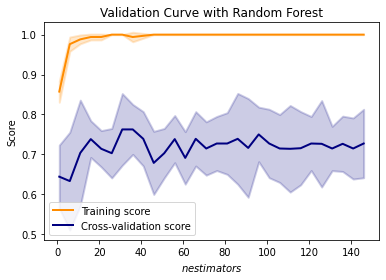

In [ ]:
# Validation curve for n_estimators of RF Classifier

# Load and adjust data
features, labels = def_data()
X_train, X_test, y_train, y_test = train_test_split(features, labels)
X_train = remove_outliers(X_train)
X_train, X_test = scaling(X_train, X_test)
X_train, X_test = remove_zero_variance(X_train, X_test)
X_train, X_test, feature_names = select_features(X_train, X_test, number = 20)

# Make validation curve
y_train = np.ravel(y_train)
param_range = list(range(1, 150, 5))
train_scores, test_scores = validation_curve(
    RandomForestClassifier(), X_train, y_train, param_name="n_estimators", param_range=param_range,
    scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve 
plt.title("Validation Curve with Random Forest")
plt.xlabel(r"$n estimators$")
plt.ylabel("Score")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
# Random Forest

def hyperrandfor(X_train, y_train):
  '''
  To fit the hyperparameters of the random-forest

  :param X_train:         dataframe containing the features of the train data           
  :param X_test:          dataframe containing the features of the test data              
  :return fitted_clfs:    list containing the fitted Random Forest classifier on the train data
  '''
  
  # Define values for hyperparameter
  n_estimators = list(range(64, 128)) 

  fitted_clfs = list()
  # Convert hyperparameters to dictionary
  hyperparameters = dict(n_estimators=n_estimators)
  # Create new RF object
  rf_clf = RandomForestClassifier()
  # Use RandomizedSearch
  clf = RandomizedSearchCV(rf_clf, hyperparameters, cv=10, n_iter=30)
  # Fit the classifier
  clf.fit(X_train, y_train)  
  # Save for next part
  fitted_clfs.append(clf)

  return fitted_clfs

In [ ]:
# Best estimators random forest 

def best_est_randf():
  '''
  To determine the optimal values for the hyperparameters for the random forest.
         
  :return best_n_estimator: best value for hyperparameter n_estimators 
  '''
  
  # Running function to determine the hyperparameters using Randomized Search
  fitted_clfs = hyperrandfor(X_train, y_train)
  
  # Get the best estimator and best parameters belonging to that estimator
  for num, clf in enumerate(fitted_clfs):
      best_n_estimators = clf.best_estimator_.get_params()['n_estimators']
  return best_n_estimators 

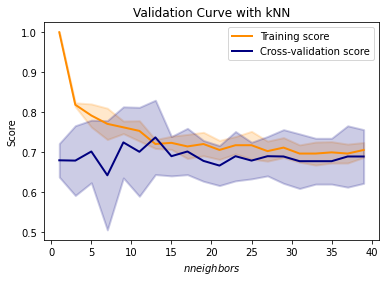

In [ ]:
# Validation curve for n_neighbors of kNN Classifier

# Load and adjust data
features, labels = def_data()
X_train, X_test, y_train, y_test = train_test_split(features, labels)
X_train = remove_outliers(X_train)
X_train, X_test = scaling(X_train, X_test)
X_train, X_test = remove_zero_variance(X_train, X_test)
X_train, X_test, feature_names = select_features(X_train, X_test, number = 20)

# Make validation curve
y_train = np.ravel(y_train)
param_range = list(range(1, 40, 2))
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors", param_range=param_range,
    scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve 
plt.title("Validation Curve with kNN")
plt.xlabel(r"$n neighbors$")
plt.ylabel("Score")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


In [ ]:
# K-nearest neighbor

def hyperknear(X_train, y_train):
  '''
  To fit the hyperparameters of the k-nearest neighbor

  :param X_train:             dataframe containing the features of the traindata           
  :param X_test:              dataframe containing the features of the testdata               
  :return fitted_clfs_knear:  list containing the fitted K-nearest neighbor classifier on the train data
  '''
  # Define values for hyperparameters
  n_neighbors = list(range(3,20,2))
  p=[1,2]
  weights = ['uniform', 'distance']

  fitted_clfs_knear = list()
  # Convert to dictionary
  hyperparameters = dict(n_neighbors=n_neighbors, p=p, weights=weights)
  # Create new KNN object
  knn_2 = KNeighborsClassifier()
  # Use RandomizedSearch
  clf = RandomizedSearchCV(knn_2, hyperparameters, cv=10, n_iter=30)
  # Fit the model
  clf.fit(X_train, y_train)
  fitted_clfs_knear.append(clf)

  return fitted_clfs_knear

In [ ]:
# Best estimators/parameters k nearest neighbor

def best_est_knear():
  '''
  To determine the optimal values for the hyperparameters for the k-Nearest Neighbor.

  :return best_p:           best value for hyperparameter p
  :return best_n_neighbors: best value for hyperparameter n_neighbors
  :return best_weights:     best weight function for hyperparameter weights
  '''
  # Running function to determine the hyperparameters using Randomized Search
  fitted_clfs_knear = hyperknear(X_train, y_train)
  
  # Get the best estimator and best parameters belonging to that estimator
  for num, clf in enumerate(fitted_clfs_knear):
      best_p = clf.best_estimator_.get_params()['p']
      best_n_neighbors = clf.best_estimator_.get_params()['n_neighbors']
      best_weights = clf.best_estimator_.get_params()['weights']
  return best_p, best_n_neighbors, best_weights

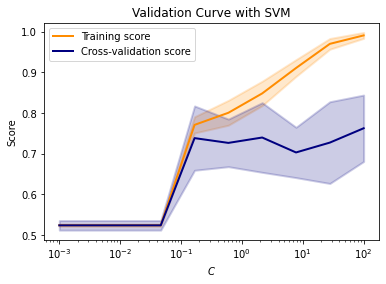

In [ ]:
# Validation curve for C of SVM Classifier

# Load and adjust data 
features, labels = def_data()
X_train, X_test, y_train, y_test = train_test_split(features, labels)
X_train = remove_outliers(X_train)
X_train, X_test = scaling(X_train, X_test)
X_train, X_test = remove_zero_variance(X_train, X_test)
X_train, X_test, feature_names = select_features(X_train, X_test, number = 20)

# Make validation curve
y_train = np.ravel(y_train)
param_range = np.logspace(-3, 2, 10)
train_scores, test_scores = validation_curve(
    SVC(), X_train, y_train, param_name="C", param_range=param_range,
    scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve 
plt.title("Validation Curve with SVM")
plt.xlabel(r"$C$")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
 # SVM

def hypersvm(X_train, y_train):
  '''
  To fit the hyperparameters of the Support Vector Machine

  :param X_train:            dataframe containing the features of the traindata           
  :param y_train:            dataframe containing the labels of the traindata        
  :return fitted_clfs_svm:   list containing the fitted SVM classifier on the train data
  '''
  
  # Define values for hyperparameters
  C = [0.01, 0.5, 1]
  kernel = ['linear', 'poly', 'rbf', 'sigmoid']
  degree = [2, 3, 4, 5]
  
  fitted_clfs_svm = list()
  # Convert to dictionary
  hyperparameters = dict(C=C, kernel=kernel, degree=degree)
  # Create new SVM object
  svm_clf = SVC()
  # Use RandomizedSearch
  clf = RandomizedSearchCV(svm_clf, hyperparameters, cv=10, n_iter=30)
  # Fit the model
  clf.fit(X_train, y_train)
  fitted_clfs_svm.append(clf)

  return fitted_clfs_svm

In [ ]:
# Best estimators/parameters SVM

def best_est_svm():
  '''
  To determine the optimal values for the hyperparameters for the Support Vector Machine.

  :return best_c:       best value for hyperparameter C
  :return best_kernel:  best kernel for hyperparameter kernel 
  :return best_degree:  best value for hyperparameter when 'poly' kernel is used 
  '''
  
  # Running function to determine the hyperparameters using Randomized Search
  fitted_clfs_svm = hypersvm(X_train, y_train)
  
  # Get the best estimator and best parameters belonging to that estimator
  for num, clf in enumerate(fitted_clfs_svm):
      best_c = clf.best_estimator_.get_params()['C']
      best_kernel = clf.best_estimator_.get_params()['kernel']
      best_degree = clf.best_estimator_.get_params()['degree']
  return best_c, best_kernel, best_degree

In [ ]:
 from sklearn.metrics  import confusion_matrix
 def evaluation(X_train, y_train, X_test, y_test, clf):
   '''
   For evaluation of the classifier, the accuracy, AUC, specificity and sensitivity
   need to be determined. 

   :param X_train: dataframe containing the features of the train data           
   :param y_train: dataframe containing the labels of the train data
   :param X_test:  dataframe containing the features of the test data
   :param y_test:  dataframe containing the labels of the test data
   :param clf:     used classifier 
   :return eval:   list contraining the values for accuracy, AUC, sensitivity 
                   and specificity for the used classifier
   '''
   # Fit the classifier on the train data
   clf.fit(X_train, y_train)
   # Predict the class of the test data using the trained classifier
   y_pred = clf.predict(X_test)
   # Determine the evaluation scores 
   accuracy = accuracy_score(y_test, y_pred)
   matrix = confusion_matrix(y_test, y_pred)
   sens = matrix[0,0] / (matrix[0,0]+matrix[0,1])
   spec = matrix[1,1] / (matrix[1,0]+matrix[1,1])
   y_pred_auc = clf.predict_proba(X_test)[:,1]
   auc = roc_auc_score(y_test, y_pred_auc)
   eval = [accuracy, auc, sens, spec]
   return eval

In [ ]:
  # Define dataframes 
  svm_df = pd.DataFrame()
  knn_df = pd.DataFrame()
  rfc_df = pd.DataFrame()
  acc_df = pd.DataFrame()
  auc_df = pd.DataFrame()
  sens_df = pd.DataFrame()
  spec_df = pd.DataFrame()
  
  # Define evaluation scores
  eval_SVM = evaluation(X_train, y_train, X_test, y_test, SVM)
  eval_KNN = evaluation(X_train, y_train, X_test, y_test, KNN)
  eval_RFC = evaluation(X_train, y_train, X_test, y_test, RFC)

  svm_df.loc[cv_ind, 0] = best_kernel
  svm_df.loc[cv_ind, 1] = best_degree
  svm_df.loc[cv_ind, 2] = best_c
  svm_df.loc[cv_ind, 3] = eval_SVM[1]

  knn_df.loc[cv_ind, 0] = best_p
  knn_df.loc[cv_ind, 1] = best_n_neighbors
  knn_df.loc[cv_ind, 2] = best_weights
  knn_df.loc[cv_ind, 3] = eval_KNN[1]

  rfc_df.loc[cv_ind, 0] = best_n_estimators
  rfc_df.loc[cv_ind, 1] = eval_RFC[1]

  acc_df.loc[cv_ind, 0] = eval_SVM[0]
  acc_df.loc[cv_ind, 1] = eval_KNN[0]
  acc_df.loc[cv_ind, 2] = eval_RFC[0]

  auc_df.loc[cv_ind, 0] = eval_SVM[1]
  auc_df.loc[cv_ind, 1] = eval_KNN[1]
  auc_df.loc[cv_ind, 2] = eval_RFC[1]

  sens_df.loc[cv_ind, 0] = eval_SVM[2]
  sens_df.loc[cv_ind, 1] = eval_KNN[2]
  sens_df.loc[cv_ind, 2] = eval_RFC[2]

  spec_df.loc[cv_ind, 0] = eval_SVM[3]
  spec_df.loc[cv_ind, 1] = eval_KNN[3]
  spec_df.loc[cv_ind, 2] = eval_RFC[3]

  return svm_df, knn_df, rfc_df, acc_df, auc_df, sens_df, spec_df


In [ ]:
def printinghyperpar(SVM, KNN, RF):
  ''' 
  Function to print the hyperparameters that were used for the different 
  classifiers per cross-validation iteration of the test data. 

  :param SVM: the SVM classifier with the trained hyperparameters 
  :param KNN: the KNN classifier with the trained hyperparameters
  :param RF:  the Random Forest classifier with the trained hyperparameters 
  '''

  print('Support Vector Machine')
  print('Hyperparameters')
  print(SVM)
  print('\n')

  print('k-Nearest Neighbors')
  print('Hyperparameters')
  print(KNN)
  print('\n')

  print('Random Forest')
  print('Hyperparameters')
  print(RF)
  print('\n')

def printingeval(acc, auc, sens, spec):
  '''
  To print all scoring results and the mean score, maximum and minimum.
  
  :param acc:  accuracy/accuracies for the used classifiers on the test data
  :param auc:  AUC(s) for the used classifiers on the test data
  :param sens: sensitivity/sensitivities for the used classifiers on the test 
               data
  :param spec: specificity/specificities for the used classifiers on the test 
               data
  '''

  print('Accuracy of all the classifiers')
  print('Results'+'\n'+'-'*80)
  print(acc)
  print('='*80)
  print('Area Under the Curve of all the classifiers')
  print('Results'+'\n'+'-'*80)
  print(auc)
  print('='*80)
  print('Sensitivity of all the classifiers')
  print('Results'+'\n'+'-'*80)
  print(sens)
  print('='*80)
  print('Specificity of all the classifiers')
  print('Results'+'\n'+'-'*80)
  print(spec)
  print('='*80)
  print('Mean accuracy:', acc['Optimal acc'].mean(), 
        '(min:', acc['Optimal acc'].min(), 'max:', 
        acc['Optimal acc'].max(), ' )')
  print('Mean AUC:', auc['Max AUC'].mean(), 
        '(min:', auc['Max AUC'].min(), 'max:', 
        auc['Max AUC'].max(), ' )')
  print('Mean sensitivity:', sens['Optimal sens'].mean(), 
        '(min:', sens['Optimal sens'].min(), 'max:', 
        sens['Optimal sens'].max(), ' )')
  print('Mean specificity:', spec['Optimal spec'].mean(), 
        '(min:', spec['Optimal spec'].min(), 'max:', 
        spec['Optimal spec'].max(), ' )')
  print('='*80)

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    if axes is None:
      _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")


    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

The number of samples: 113
The number of columns: 160


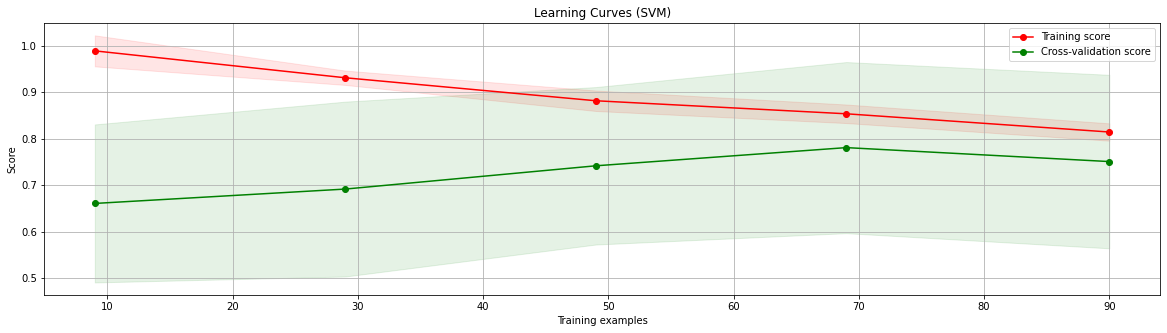

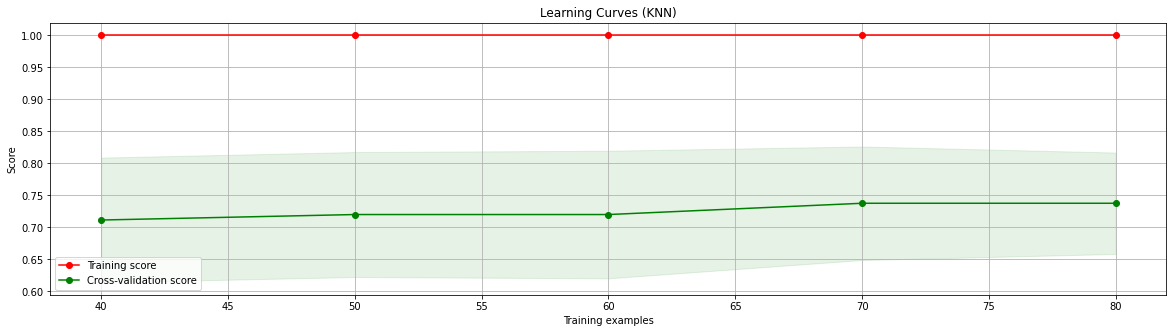

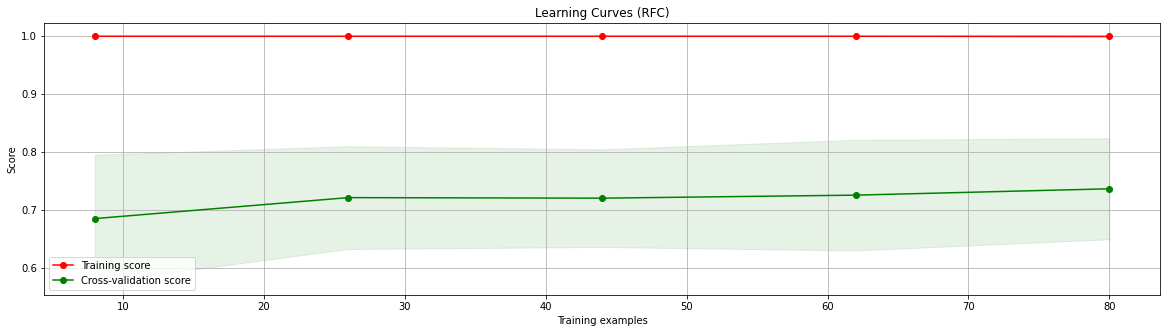

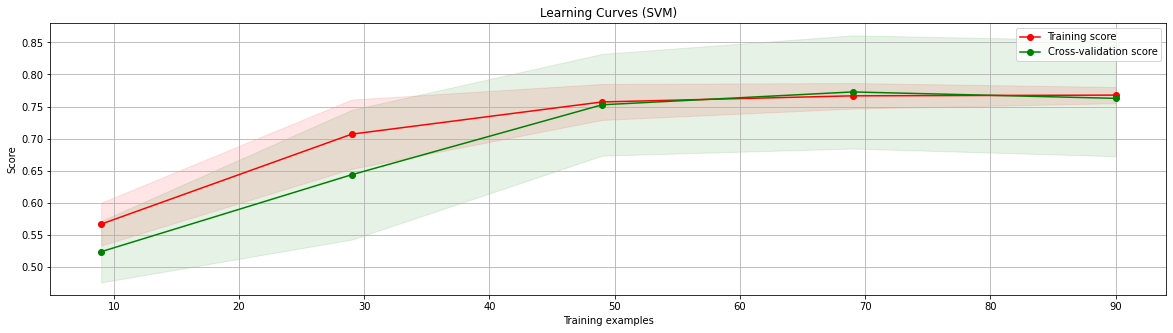

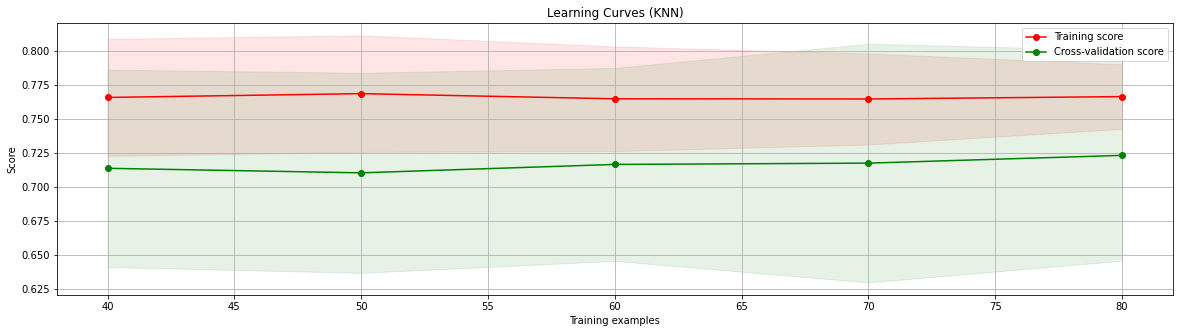

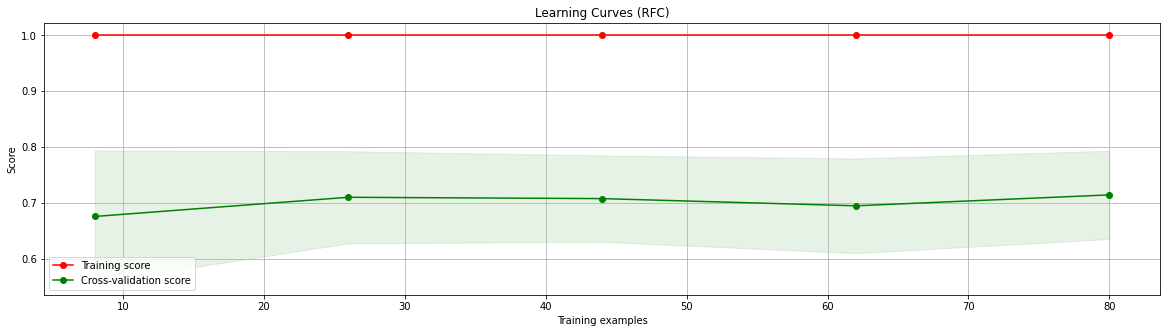

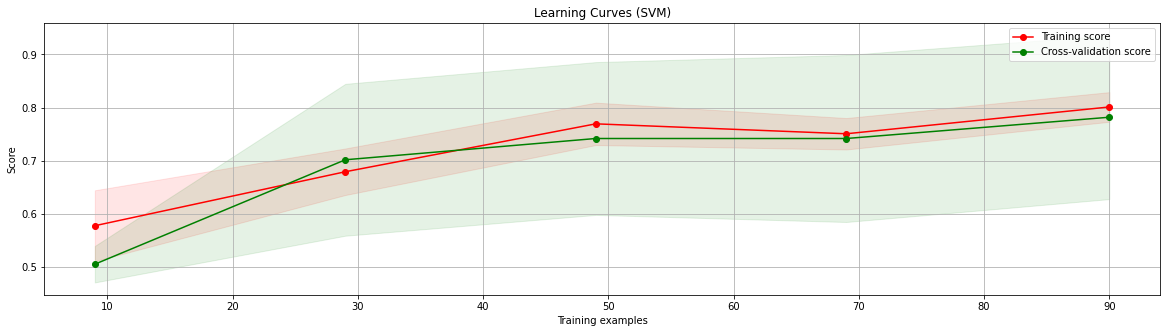

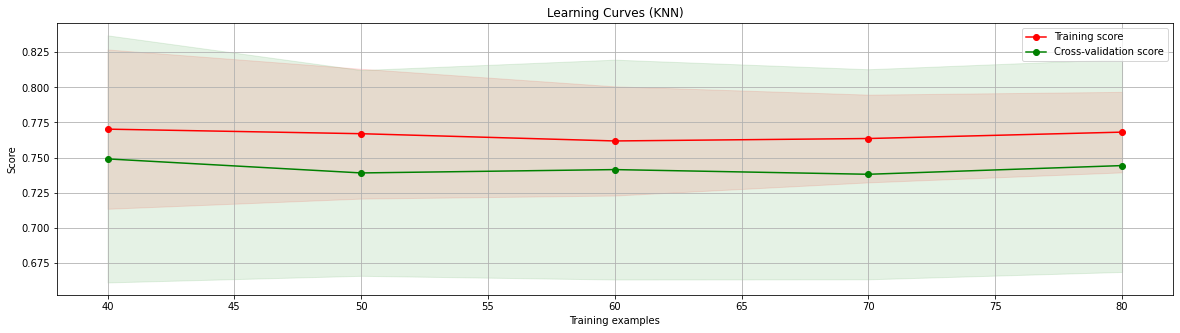

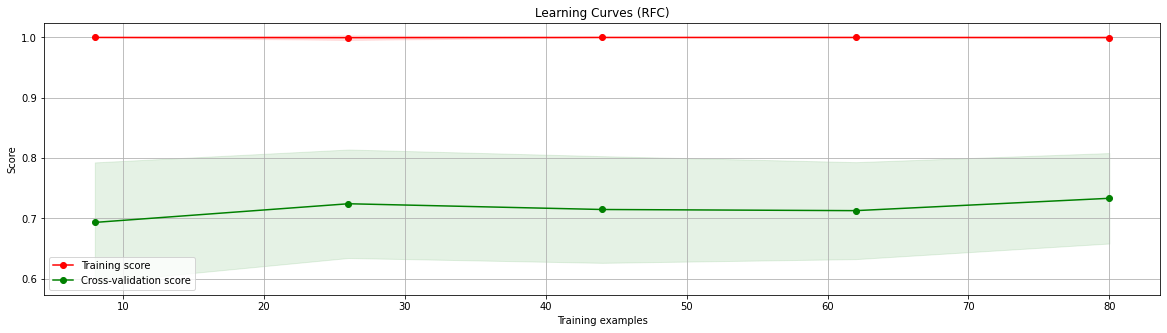

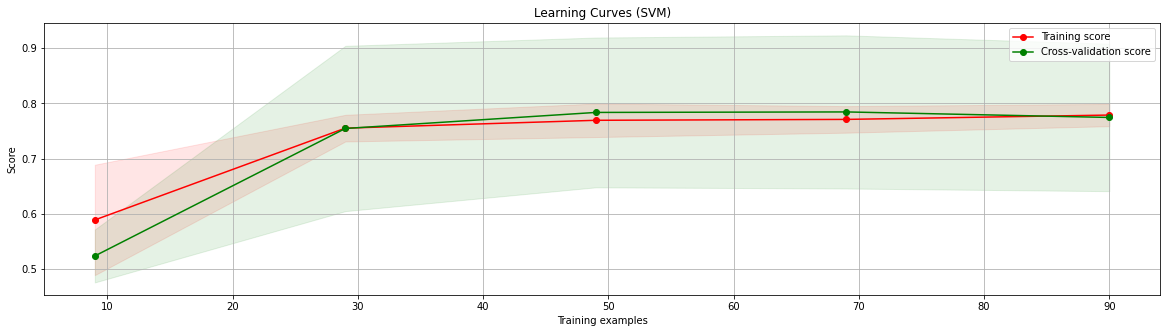

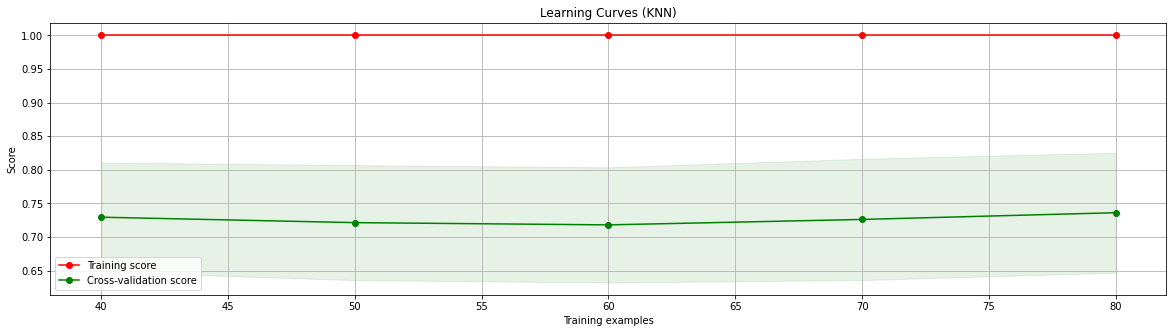

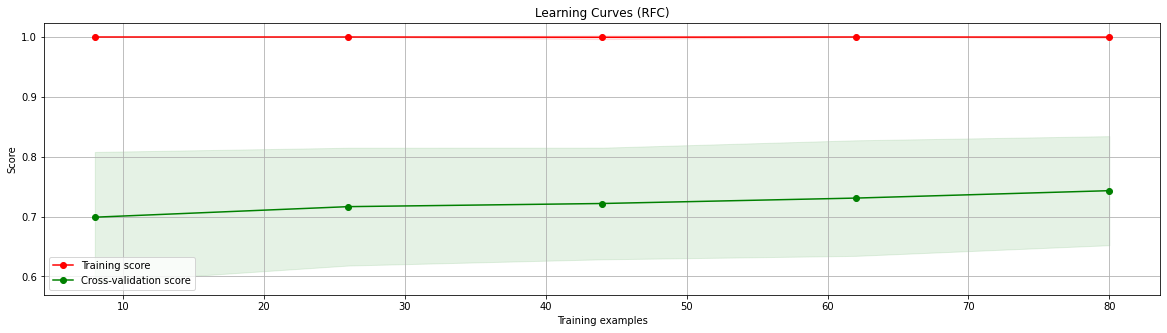

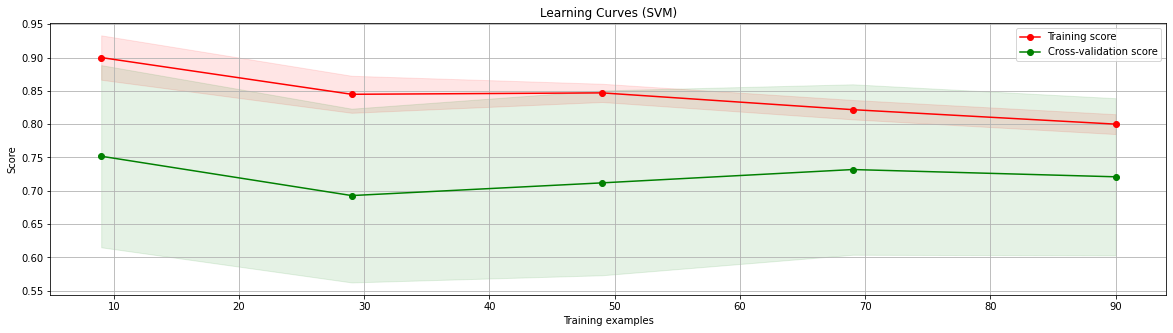

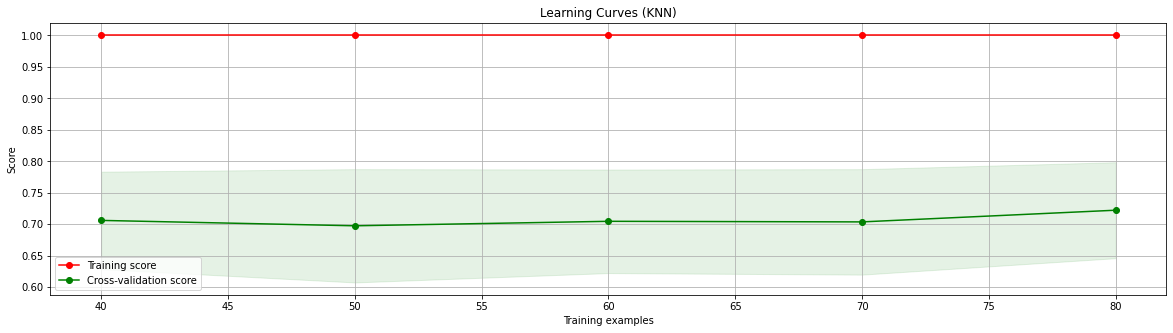

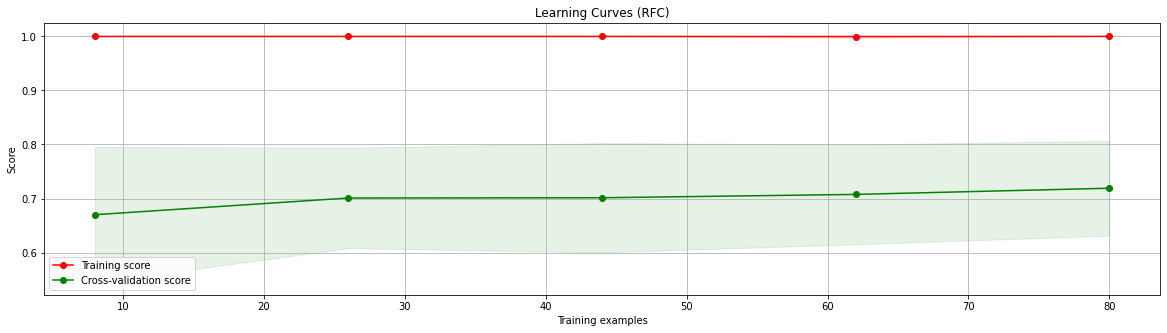

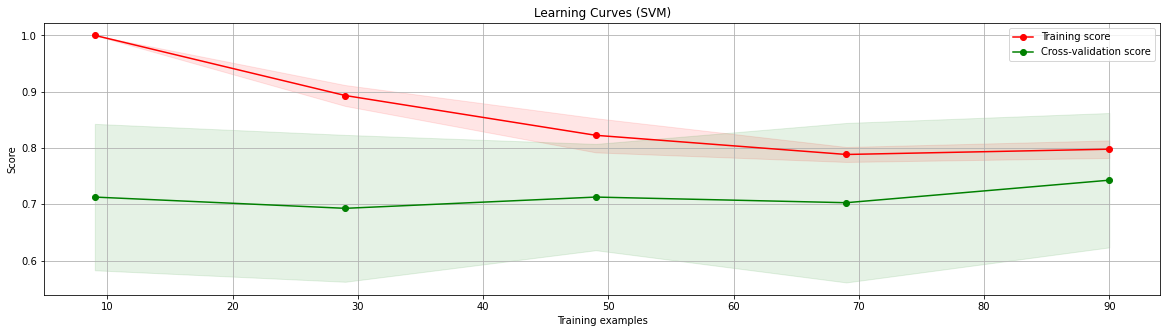

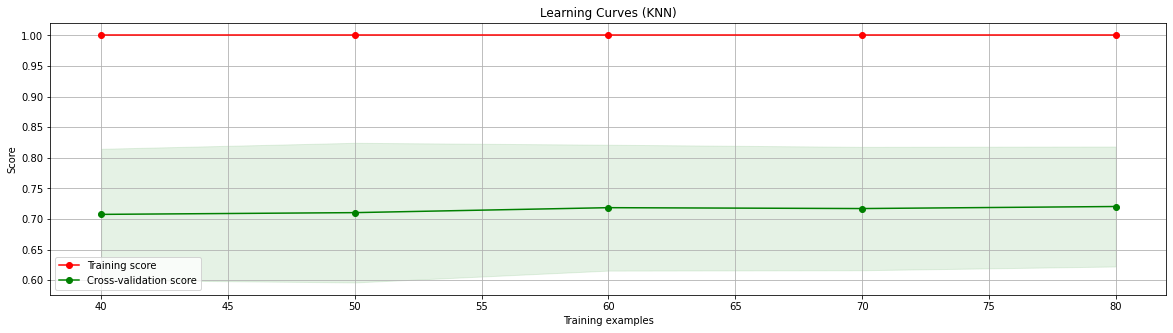

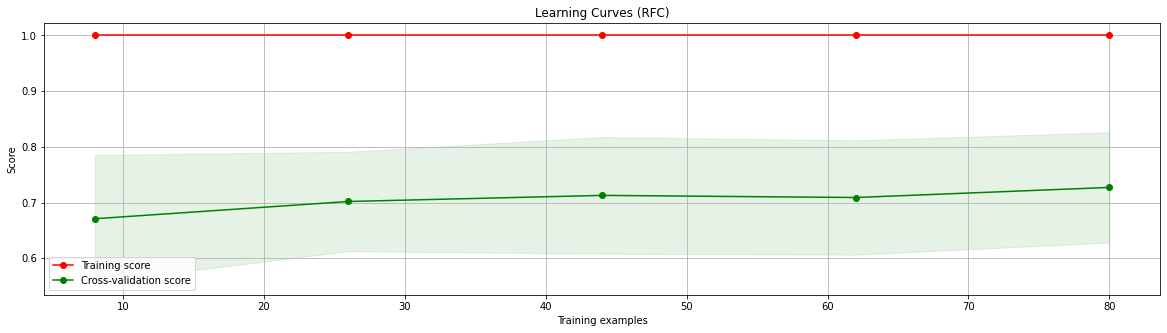

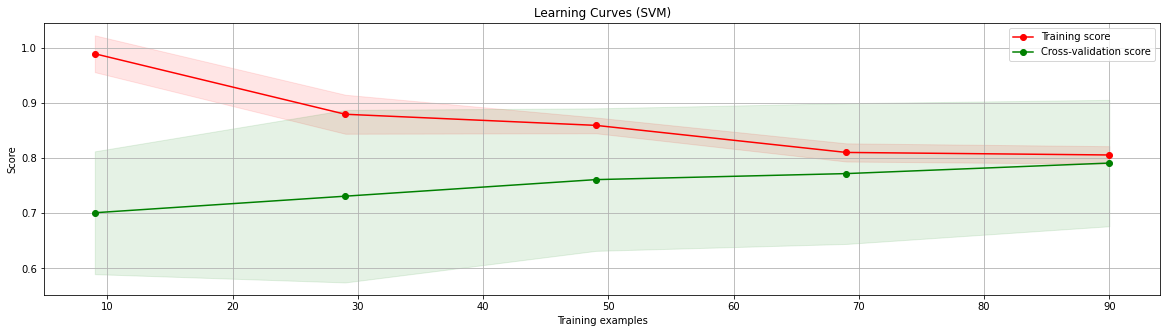

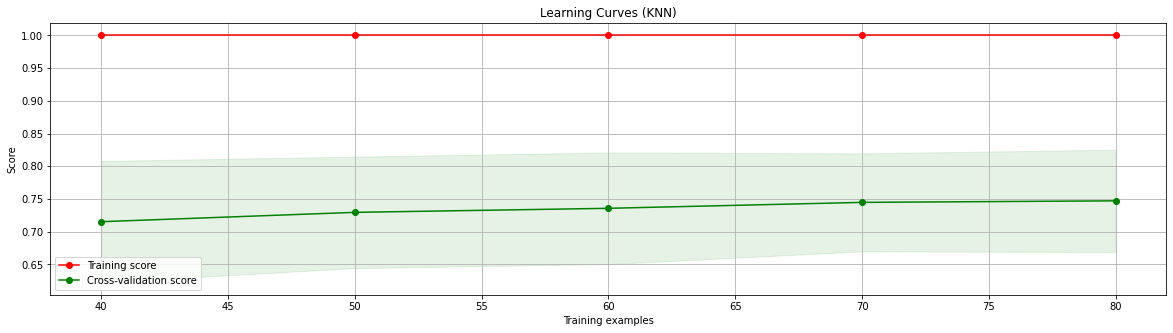

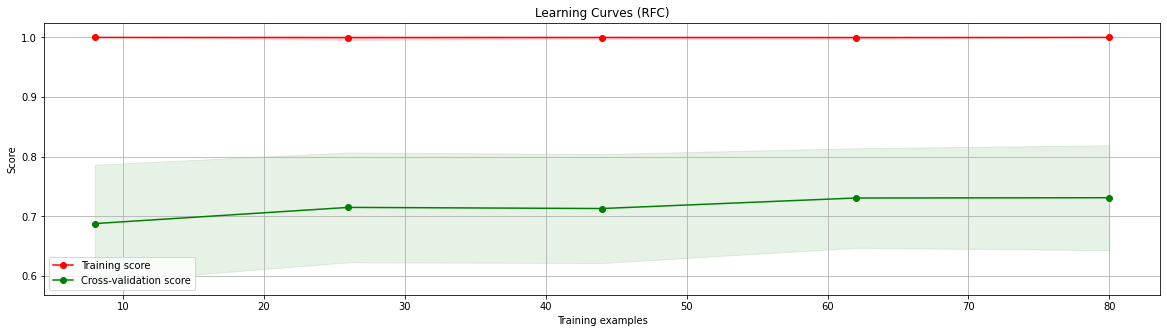

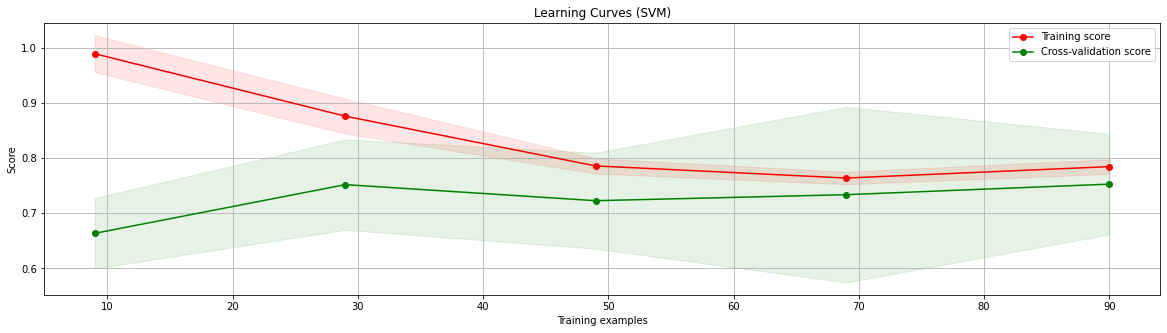

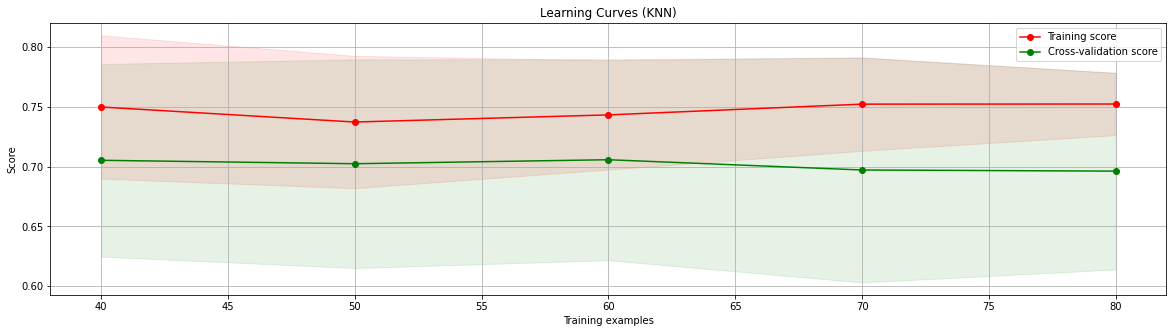

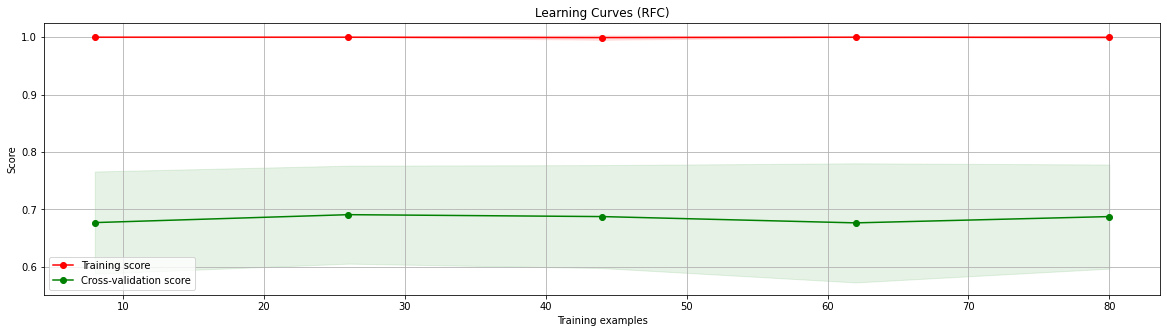

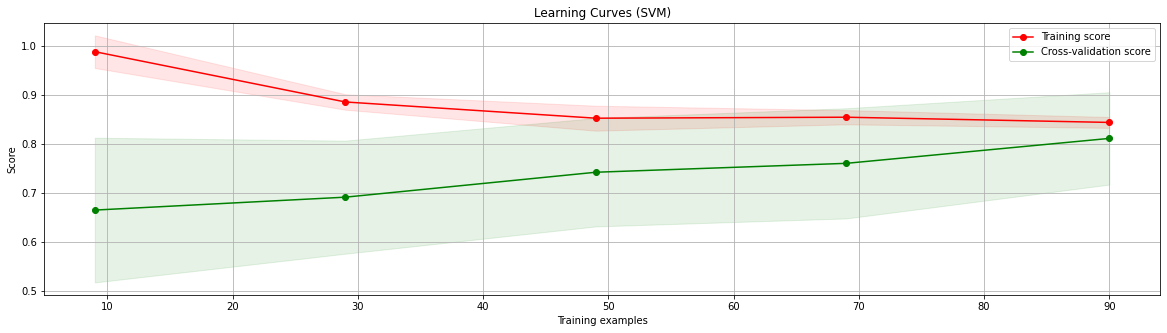

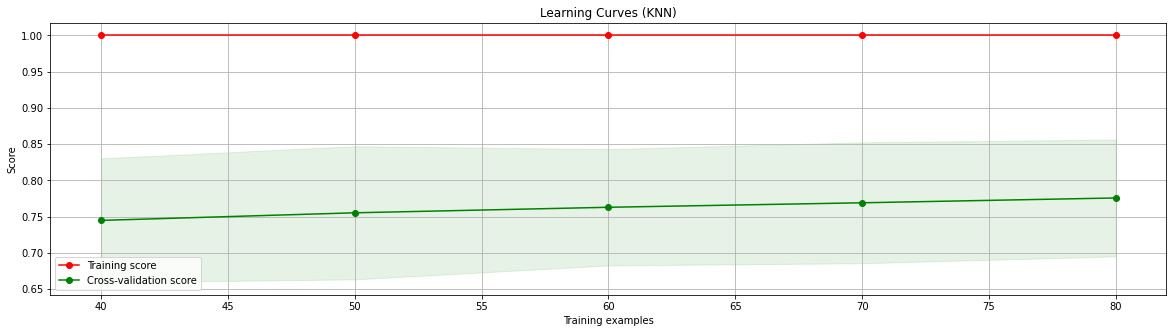

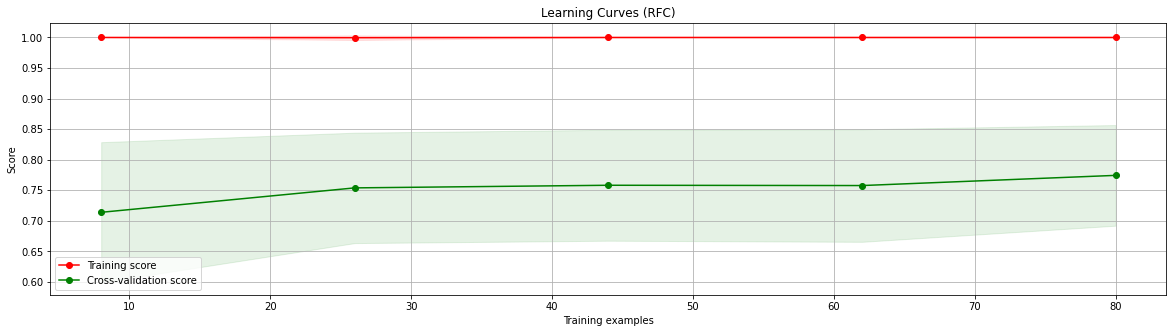

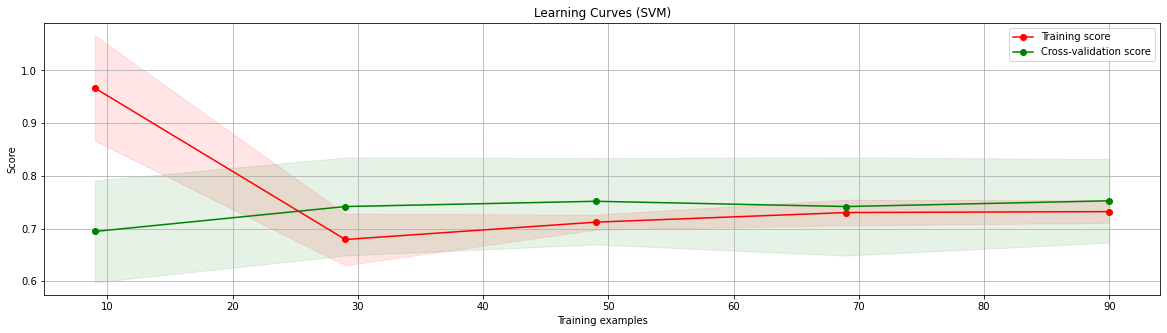

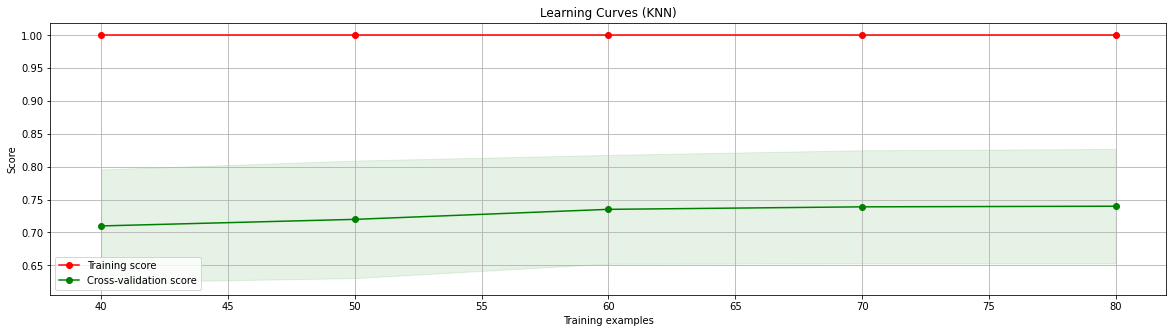

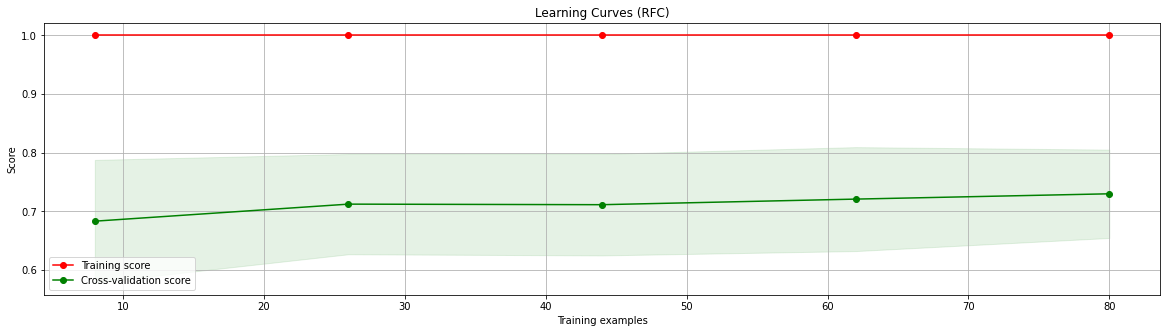

,Kernel,Degree,C,Accuracy
0,linear,4.0,0.50,0.666667
1,linear,4.0,0.01,0.833333
2,linear,5.0,0.01,0.666667
3,rbf,4.0,0.50,0.583333
4,linear,2.0,0.50,1.000000
5,rbf,2.0,1.00,0.833333
6,linear,3.0,1.00,0.750000
7,linear,2.0,0.50,0.916667
8,rbf,3.0,1.00,0.416667
9,sigmoid,2.0,0.50,0.833333


In [ ]:
# Run one time:
features, labels = def_data()

# In the train test loop
sss = StratifiedShuffleSplit(n_splits=10)

# Define empty dataframe to save all parameters and evaluation scores 
svm_df_all = pd.DataFrame()
knn_df_all = pd.DataFrame()
rfc_df_all = pd.DataFrame()
acc_df_all = pd.DataFrame()
auc_df_all = pd.DataFrame()
sens_df_all = pd.DataFrame()
spec_df_all = pd.DataFrame()
features_df = pd.DataFrame()

# Index of the split
cv_ind = 0
# Use stratified shuffle split for data split, train classifiers and determine evaluation scores
for train_index, test_index in sss.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    y_train = np.ravel(y_train)
    
    X_train = remove_outliers(X_train)
    X_train, X_test = scaling(X_train, X_test)
    X_train, X_test = remove_zero_variance(X_train, X_test)
    X_train, X_test, feature_names = select_features(X_train, X_test)
    run = cv_ind + 1
    features_df['Run {}'.format(run)] = feature_names
    
    svm_df, knn_df, rfc_df, acc_df, auc_df, sens_df, spec_df = constrclassandacc(X_train, y_train, X_test, y_test, cv_ind)
    svm_df_all = svm_df_all.append(svm_df)
    knn_df_all = knn_df_all.append(knn_df)
    rfc_df_all = rfc_df_all.append(rfc_df)
    acc_df_all = acc_df_all.append(acc_df)
    auc_df_all = auc_df_all.append(auc_df)
    sens_df_all = sens_df_all.append(sens_df)
    spec_df_all = spec_df_all.append(spec_df)

    cv_ind += 1

    best_n_estimators = best_est_randf()
    best_p, best_n_neighbors, best_weights = best_est_knear()
    best_c, best_kernel, best_degree = best_est_svm()

    SVM = SVC(kernel=best_kernel, degree=best_degree, C=best_c, probability=True)
    KNN = KNeighborsClassifier(p=best_p, n_neighbors=best_n_neighbors, weights=best_weights)
    RFC = RandomForestClassifier(n_estimators=best_n_estimators)
    
    cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

    title = r"Learning Curves (SVM)"
    plt = plot_learning_curve(SVM, title, X_train, y_train, ylim=None, cv=10,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    title = r"Learning Curves (KNN)"
    plt = plot_learning_curve(KNN, title, X_train, y_train, ylim=None,
                              cv=cv, n_jobs=4, train_sizes=np.linspace(0.5, 1.0, 5))

    title = r"Learning Curves (RFC)"
    plt = plot_learning_curve(RFC, title, X_train, y_train, ylim=None, cv=cv,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    plt.show()

svm_df_all.columns = ['Kernel', 'Degree', 'C', 'Accuracy']
knn_df_all.columns = ['P', 'N Neighbors', 'Weights', 'Accuracy']
rfc_df_all.columns = ['N estimators', 'Accuracy']
acc_df_all.columns = ['Acc SVM', 'Acc KNN', 'Acc RFC']
acc_df_all['Max Acc'] = acc_df_all.max(axis=1)
auc_df_all.columns = ['AUC SVM', 'AUC KNN', 'AUC RFC']
auc_df_all['Max AUC'] = auc_df_all.max(axis=1)
sens_df_all.columns = ['Sens SVM', 'Sens KNN', 'Sens RFC']
sens_df_all['Max Sens'] = sens_df_all.max(axis=1)
spec_df_all.columns = ['Spec SVM', 'Spec KNN', 'Spec RFC']
spec_df_all['Max Spec'] = spec_df_all.max(axis=1)

svm_df_all